In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg
import os
import pickle
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

## Acquisition Functions

In [2]:
cf = 0.15

In [3]:
def createDataFrame(data_path):
    """
    input: data_path: path to data
    return: data frame
    """
    data_frame = pd.read_csv(data_path)
    data_frame.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    return data_frame

In [4]:
def createTrainingDataPathsCenterLeftRightPrefixGood(df, correction_factor, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    measurements = []
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        # center images
        center_images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
        measurements.append(row['steering'])

        # left images
        left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
        measurements.append(row['steering'] - correction_factor)

        # right images
        right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
        measurements.append(row['steering'] + correction_factor)

    return (np.asarray(center_images), np.asarray(left_images), np.asarray(right_images), np.asarray(measurements, dtype=np.float32))

In [5]:
# def createTrainingDataPathsCLR(df, correction_factor, prefix_path):
#     """
#     creates training data and training labels/ measurements from a data frame
#     inputs:
#     df: pandas DataFrame object
#     start: starting row to grab data
#     end: ending row to grab data
#     correction_factor: factor to correct steering angles
#     """
#     center_images = []
#     left_images = []
#     right_images = []
    
#     center_measurements = []
#     left_measurements = []
#     right_measurements = []
    
#     abs_path_to_IMG = os.path.abspath(prefix_path)
#     for idx, row in df.iterrows():
#         # center images
#         center_images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
#         center_measurements.append(row['steering'])

#         # left images
#         left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
#         left_measurements.append(row['steering'] - correction_factor)

#         # right images
#         right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
#         right_measurements.append(row['steering'] + correction_factor)
            
#     return (
#         np.asarray(center_images),
#         np.asarray(left_images),
#         np.asarray(right_images),
#         np.asarray(center_measurements, dtype=np.float32),
#         np.asarray(left_measurements, dtype=np.float32),
#         np.asarray(right_measurements, dtype=np.float32),
#     )

In [ ]:
def createTrainingDataPathsCLR(df, correction_factor, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    
    center_measurements = []
    left_measurements = []
    right_measurements = []
    
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        # center images
        center_images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
        center_measurements.append(row['steering'])

        # left images
        left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
        left_measurements.append(row['steering'] - correction_factor)

        # right images
        right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
        right_measurements.append(row['steering'] + correction_factor)
            
    return (
        np.asarray(center_images),
        np.asarray(left_images),
        np.asarray(right_images),
        np.asarray(center_measurements, dtype=np.float32),
        np.asarray(left_measurements, dtype=np.float32),
        np.asarray(right_measurements, dtype=np.float32),
    )

In [6]:
def removeZerosFromCenter(X, y, rang = 0.1):
    low = -1 * rang
    high = rang
    is_y_in_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_in_range]
    y = y[is_y_in_range]
    return X,y

In [7]:
def removeZerosFromLeft(X, y, correction_factor, rang = 0.1):
    low = -1 * (correction_factor + rang)
    high = -1 * (correction_factor - rang)
    is_y_in_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_in_range]
    y = y[is_y_in_range]
    return X, y

In [8]:
def removeZerosFromRight(X, y, correction_factor, rang = 0.1):
    high = correction_factor + rang
    low = correction_factor - rang
    is_y_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_range]
    y = y[is_y_range]
    return X, y

### Create data from dirt recovery (ccw)

In [9]:
data_pd_dirt_c1 = createDataFrame('A_Recovery_right_lane_dirt/driving_log.csv')

In [10]:
(X_train_dirt_c1_c, 
X_train_dirt_c1_l, 
X_train_dirt_c1_r, 
y_train_dirt_c1_c,
y_train_dirt_c1_l,
y_train_dirt_c1_r) = createTrainingDataPathsCLR(data_pd_dirt_c1, cf, '.')

In [11]:
print('X_train_dirt_c1_c shape: ', X_train_dirt_c1_c.shape)
print('y_train_dirt_c1_c shape: ', y_train_dirt_c1_c.shape)
print('y_train_dirt_c1_l shape: ', X_train_dirt_c1_l.shape)
print('X_train_dirt_c1_l shape: ', y_train_dirt_c1_l.shape)
print('X_train_dirt_c1_r shape: ', X_train_dirt_c1_r.shape)
print('y_train_dirt_c1_r shape: ', y_train_dirt_c1_r.shape)

X_train_dirt_c1_c shape:  (309,)
y_train_dirt_c1_c shape:  (309,)
y_train_dirt_c1_l shape:  (309,)
X_train_dirt_c1_l shape:  (309,)
X_train_dirt_c1_r shape:  (309,)
y_train_dirt_c1_r shape:  (309,)


remove steering data with zeros

In [12]:
print(cf)

0.15


In [13]:
X_train_dirt_c1_c, y_train_dirt_c1_c = removeZerosFromCenter(X_train_dirt_c1_c, y_train_dirt_c1_c)
X_train_dirt_c1_l, y_train_dirt_c1_l = removeZerosFromLeft(X_train_dirt_c1_l, y_train_dirt_c1_l, cf)
X_train_dirt_c1_r, y_train_dirt_c1_r = removeZerosFromRight(X_train_dirt_c1_r, y_train_dirt_c1_r, cf)

In [14]:
print('X_train_dirt_c1_c shape: ', X_train_dirt_c1_c.shape)
print('y_train_dirt_c1_c shape: ', y_train_dirt_c1_c.shape)
print('y_train_dirt_c1_l shape: ', X_train_dirt_c1_l.shape)
print('X_train_dirt_c1_l shape: ', y_train_dirt_c1_l.shape)
print('X_train_dirt_c1_r shape: ', X_train_dirt_c1_r.shape)
print('y_train_dirt_c1_r shape: ', y_train_dirt_c1_r.shape)

X_train_dirt_c1_c shape:  (159,)
y_train_dirt_c1_c shape:  (159,)
y_train_dirt_c1_l shape:  (159,)
X_train_dirt_c1_l shape:  (159,)
X_train_dirt_c1_r shape:  (159,)
y_train_dirt_c1_r shape:  (159,)


append them together

In [15]:
X_train_dirt_c1 = np.append(X_train_dirt_c1_c, X_train_dirt_c1_l, axis = 0)
X_train_dirt_c1 = np.append(X_train_dirt_c1, X_train_dirt_c1_r, axis = 0)
print('X_train_dirt_c1 shape: ', X_train_dirt_c1.shape)
y_train_dirt_c1 = np.append(y_train_dirt_c1_c, y_train_dirt_c1_l, axis = 0)
y_train_dirt_c1 = np.append(y_train_dirt_c1, y_train_dirt_c1_r, axis = 0)
print('y_train_dirt_c1 shape: ', y_train_dirt_c1.shape)

X_train_dirt_c1 shape:  (477,)
y_train_dirt_c1 shape:  (477,)


### <font color='green'>=> X_train_dirt_c1, y_train_dirt_c1</font>

### Create data from recovery_by_lake_1 (cw)

In [16]:
data_pd_lake_c1 = createDataFrame('recovery_cw_bylake/driving_log.csv')

In [17]:
(X_train_lake_c1_c, 
X_train_lake_c1_l, 
X_train_lake_c1_r, 
y_train_lake_c1_c,
y_train_lake_c1_l,
y_train_lake_c1_r) = createTrainingDataPathsCLR(data_pd_lake_c1, cf, '.')

remove steering data with zeros

In [18]:
X_train_lake_c1_c, y_train_lake_c1_c = removeZerosFromCenter(X_train_lake_c1_c, y_train_lake_c1_c)
X_train_lake_c1_l, y_train_lake_c1_l = removeZerosFromLeft(X_train_lake_c1_l, y_train_lake_c1_l, cf)
X_train_lake_c1_r, y_train_lake_c1_r = removeZerosFromRight(X_train_lake_c1_r, y_train_lake_c1_r, cf)

In [19]:
print('X_train_lake_c1_c shape: ', X_train_lake_c1_c.shape)
print('y_train_lake_c1_c shape: ', y_train_lake_c1_c.shape)
print('y_train_lake_c1_l shape: ', X_train_lake_c1_l.shape)
print('X_train_lake_c1_l shape: ', y_train_lake_c1_l.shape)
print('X_train_lake_c1_r shape: ', X_train_lake_c1_r.shape)
print('y_train_lake_c1_r shape: ', y_train_lake_c1_r.shape)

X_train_lake_c1_c shape:  (385,)
y_train_lake_c1_c shape:  (385,)
y_train_lake_c1_l shape:  (385,)
X_train_lake_c1_l shape:  (385,)
X_train_lake_c1_r shape:  (385,)
y_train_lake_c1_r shape:  (385,)


append them together

In [20]:
X_train_lake_c1 = np.append(X_train_lake_c1_c, X_train_lake_c1_l, axis = 0)
X_train_lake_c1 = np.append(X_train_lake_c1, X_train_lake_c1_r, axis = 0)
print('X_train_lake_c1 shape: ', X_train_lake_c1.shape)
y_train_lake_c1 = np.append(y_train_lake_c1_c, y_train_lake_c1_l, axis = 0)
y_train_lake_c1 = np.append(y_train_lake_c1, y_train_lake_c1_r, axis = 0)
print('y_train_lake_c1 shape: ', y_train_lake_c1.shape)

X_train_lake_c1 shape:  (1155,)
y_train_lake_c1 shape:  (1155,)


### <font color='green'>=> X_train_lake_c1, y_train_lake_c1</font>

### Create data from recovery_by_lake_cw_2

In [21]:
data_pd_lake_c2 = createDataFrame('recovery_cw_by_lake_2/driving_log.csv')

In [22]:
(X_train_lake_c2_c, 
X_train_lake_c2_l, 
X_train_lake_c2_r, 
y_train_lake_c2_c,
y_train_lake_c2_l,
y_train_lake_c2_r) = createTrainingDataPathsCLR(data_pd_lake_c2, cf, '.')

remove steering data with zeros

In [23]:
X_train_lake_c2_c, y_train_lake_c2_c = removeZerosFromCenter(X_train_lake_c2_c, y_train_lake_c2_c)
X_train_lake_c2_l, y_train_lake_c2_l = removeZerosFromLeft(X_train_lake_c2_l, y_train_lake_c2_l, cf)
X_train_lake_c2_r, y_train_lake_c2_r = removeZerosFromRight(X_train_lake_c2_r, y_train_lake_c2_r, cf)

In [24]:
print('X_train_lake_c2_c shape: ', X_train_lake_c2_c.shape)
print('y_train_lake_c2_c shape: ', y_train_lake_c2_c.shape)
print('y_train_lake_c2_l shape: ', X_train_lake_c2_l.shape)
print('X_train_lake_c2_l shape: ', y_train_lake_c2_l.shape)
print('X_train_lake_c2_r shape: ', X_train_lake_c2_r.shape)
print('y_train_lake_c2_r shape: ', y_train_lake_c2_r.shape)

X_train_lake_c2_c shape:  (116,)
y_train_lake_c2_c shape:  (116,)
y_train_lake_c2_l shape:  (116,)
X_train_lake_c2_l shape:  (116,)
X_train_lake_c2_r shape:  (116,)
y_train_lake_c2_r shape:  (116,)


append them together

In [25]:
X_train_lake_c2 = np.append(X_train_lake_c2_c, X_train_lake_c2_l, axis = 0)
X_train_lake_c2 = np.append(X_train_lake_c2, X_train_lake_c2_r, axis = 0)
print('X_train_lake_c2 shape: ', X_train_lake_c2.shape)
y_train_lake_c2 = np.append(y_train_lake_c2_c, y_train_lake_c2_l, axis = 0)
y_train_lake_c2 = np.append(y_train_lake_c2, y_train_lake_c2_r, axis = 0)
print('y_train_lake_c2 shape: ', y_train_lake_c2.shape)

X_train_lake_c2 shape:  (348,)
y_train_lake_c2 shape:  (348,)


### <font color='green'>=> X_train_lake_c2, y_train_lake_c2</font>

### Create data from ken dirt recovery_set1 (dirt2)

In [26]:
data_pd_dirt2_cw = createDataFrame('controller_dirt_track1_set1_cw/driving_log.csv')

In [27]:
(X_train_dirt2_cw_c, 
X_train_dirt2_cw_l, 
X_train_dirt2_cw_r, 
y_train_dirt2_cw_c,
y_train_dirt2_cw_l,
y_train_dirt2_cw_r) = createTrainingDataPathsCLR(data_pd_dirt2_cw, 0.15, 'controller_dirt_track1_set1_cw/')

X_train_dirt2_cw_c, y_train_dirt2_cw_c = removeZerosFromCenter(X_train_dirt2_cw_c, y_train_dirt2_cw_c)
X_train_dirt2_cw_l, y_train_dirt2_cw_l = removeZerosFromLeft(X_train_dirt2_cw_l, y_train_dirt2_cw_l, cf)
X_train_dirt2_cw_r, y_train_dirt2_cw_r = removeZerosFromRight(X_train_dirt2_cw_r, y_train_dirt2_cw_r, cf)

print('X_train_dirt2_cw_c shape: ', X_train_dirt2_cw_c.shape)
print('y_train_dirt2_cw_c shape: ', y_train_dirt2_cw_c.shape)
print('y_train_dirt2_cw_l shape: ', X_train_dirt2_cw_l.shape)
print('X_train_dirt2_cw_l shape: ', y_train_dirt2_cw_l.shape)
print('X_train_dirt2_cw_r shape: ', X_train_dirt2_cw_r.shape)
print('y_train_dirt2_cw_r shape: ', y_train_dirt2_cw_r.shape)

X_train_dirt2_cw = np.append(X_train_dirt2_cw_c, X_train_dirt2_cw_l, axis = 0)
X_train_dirt2_cw = np.append(X_train_dirt2_cw, X_train_dirt2_cw_r, axis = 0)
print('X_train_dirt2_cw shape: ', X_train_dirt2_cw.shape)
y_train_dirt2_cw = np.append(y_train_dirt2_cw_c, y_train_dirt2_cw_l, axis = 0)
y_train_dirt2_cw = np.append(y_train_dirt2_cw, y_train_dirt2_cw_r, axis = 0)
print('y_train_dirt2_cw shape: ', y_train_dirt2_cw.shape)

X_train_dirt2_cw_c shape:  (1558,)
y_train_dirt2_cw_c shape:  (1558,)
y_train_dirt2_cw_l shape:  (1558,)
X_train_dirt2_cw_l shape:  (1558,)
X_train_dirt2_cw_r shape:  (1558,)
y_train_dirt2_cw_r shape:  (1558,)
X_train_dirt2_cw shape:  (4674,)
y_train_dirt2_cw shape:  (4674,)


### <font color='green'>=> X_train_dirt2_cw, y_train_dirt2_cw</font>#

### Create data from ken dirt recovery_set2 (dirt3)

In [28]:
data_pd_dirt3_cw = createDataFrame('controller_dirt_track1_set2_cw/driving_log.csv')

In [29]:
(X_train_dirt3_cw_c, 
X_train_dirt3_cw_l, 
X_train_dirt3_cw_r, 
y_train_dirt3_cw_c,
y_train_dirt3_cw_l,
y_train_dirt3_cw_r) = createTrainingDataPathsCLR(data_pd_dirt3_cw, 0.15, 'controller_dirt_track1_set2_cw/')

X_train_dirt3_cw_c, y_train_dirt3_cw_c = removeZerosFromCenter(X_train_dirt3_cw_c, y_train_dirt3_cw_c)
X_train_dirt3_cw_l, y_train_dirt3_cw_l = removeZerosFromLeft(X_train_dirt3_cw_l, y_train_dirt3_cw_l, cf)
X_train_dirt3_cw_r, y_train_dirt3_cw_r = removeZerosFromRight(X_train_dirt3_cw_r, y_train_dirt3_cw_r, cf)

print('X_train_dirt3_cw_c shape: ', X_train_dirt3_cw_c.shape)
print('y_train_dirt3_cw_c shape: ', y_train_dirt3_cw_c.shape)
print('y_train_dirt3_cw_l shape: ', X_train_dirt3_cw_l.shape)
print('X_train_dirt3_cw_l shape: ', y_train_dirt3_cw_l.shape)
print('X_train_dirt3_cw_r shape: ', X_train_dirt3_cw_r.shape)
print('y_train_dirt3_cw_r shape: ', y_train_dirt3_cw_r.shape)

X_train_dirt3_cw = np.append(X_train_dirt3_cw_c, X_train_dirt3_cw_l, axis = 0)
X_train_dirt3_cw = np.append(X_train_dirt3_cw, X_train_dirt3_cw_r, axis = 0)
print('X_train_dirt3_cw shape: ', X_train_dirt3_cw.shape)
y_train_dirt3_cw = np.append(y_train_dirt3_cw_c, y_train_dirt3_cw_l, axis = 0)
y_train_dirt3_cw = np.append(y_train_dirt3_cw, y_train_dirt3_cw_r, axis = 0)
print('y_train_dirt3_cw shape: ', y_train_dirt3_cw.shape)

X_train_dirt3_cw_c shape:  (218,)
y_train_dirt3_cw_c shape:  (218,)
y_train_dirt3_cw_l shape:  (218,)
X_train_dirt3_cw_l shape:  (218,)
X_train_dirt3_cw_r shape:  (218,)
y_train_dirt3_cw_r shape:  (218,)
X_train_dirt3_cw shape:  (654,)
y_train_dirt3_cw shape:  (654,)


### Create data from turn before bridge

In [30]:
data_pd_bridge = createDataFrame('turn_before_bridge/driving_log.csv')

In [31]:
(X_train_bridge_c, 
X_train_bridge_l, 
X_train_bridge_r, 
y_train_bridge_c,
y_train_bridge_l,
y_train_bridge_r) = createTrainingDataPathsCLR(data_pd_bridge, 0.15, '.')

X_train_bridge_c, y_train_bridge_c = removeZerosFromCenter(X_train_bridge_c, y_train_bridge_c)
X_train_bridge_l, y_train_bridge_l = removeZerosFromLeft(X_train_bridge_l, y_train_bridge_l, cf)
X_train_bridge_r, y_train_bridge_r = removeZerosFromRight(X_train_bridge_r, y_train_bridge_r, cf)

print('X_train_bridge_c shape: ', X_train_bridge_c.shape)
print('y_train_bridge_c shape: ', y_train_bridge_c.shape)
print('y_train_bridge_l shape: ', X_train_bridge_l.shape)
print('X_train_bridge_l shape: ', y_train_bridge_l.shape)
print('X_train_bridge_r shape: ', X_train_bridge_r.shape)
print('y_train_bridge_r shape: ', y_train_bridge_r.shape)

X_train_bridge = np.append(X_train_bridge_c, X_train_bridge_l, axis = 0)
X_train_bridge = np.append(X_train_bridge, X_train_bridge_r, axis = 0)
print('X_train_bridge shape: ', X_train_bridge.shape)
y_train_bridge = np.append(y_train_bridge_c, y_train_bridge_l, axis = 0)
y_train_bridge = np.append(y_train_bridge, y_train_bridge_r, axis = 0)
print('y_train_cwr2 shape: ', y_train_bridge.shape)

X_train_bridge_c shape:  (333,)
y_train_bridge_c shape:  (333,)
y_train_bridge_l shape:  (333,)
X_train_bridge_l shape:  (333,)
X_train_bridge_r shape:  (333,)
y_train_bridge_r shape:  (333,)
X_train_bridge shape:  (999,)
y_train_cwr2 shape:  (999,)


### <font color='green'>=> X_train_dirt3_cw, y_train_dirt3_cw</font>#

### Create data from udacity

(160, 320, 3)


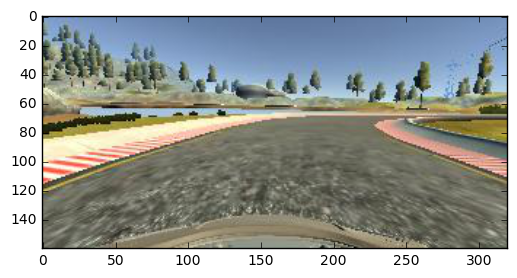

In [32]:
impath = X_train_dirt3_cw[100]
img = mpimg.imread(impath)
print(img.shape)
plt.imshow(img)

In [33]:
data_pd_cw2 = createDataFrame('data/driving_log.csv')
X_train_cw2_c, X_train_cw2_l, X_train_cw2_r, y_train_cw2 = createTrainingDataPathsCenterLeftRightPrefixGood(data_pd_cw2, cf, 'data/')
# data_pd_cw2.hist(column = 'throttle')
X_train_udacity = np.append(X_train_cw2_c, X_train_cw2_l, axis = 0)
X_train_udacity = np.append(X_train_udacity, X_train_cw2_r, axis = 0)
y_train_udacity = y_train_cw2
print('shape of X_train_udacity: ', X_train_udacity.shape)
print('shape of y_train_udacity: ', y_train_udacity.shape)

shape of X_train_udacity:  (24108,)
shape of y_train_udacity:  (24108,)


In [34]:
# Create more udacity data 
(X_train_cw2_c, 
X_train_cw2_l, 
X_train_cw2_r, 
y_train_cw2_c,
y_train_cw2_l,
y_train_cw2_r) = createTrainingDataPathsCLR(data_pd_cw2, 0.15, 'data/')

In [35]:
print('X_train_cw2_c shape: ', X_train_cw2_c.shape)
print('y_train_cw2_c shape: ', y_train_cw2_c.shape)
print('y_train_cw2_l shape: ', X_train_cw2_l.shape)
print('X_train_cw2_l shape: ', y_train_cw2_l.shape)
print('X_train_cw2_r shape: ', X_train_cw2_r.shape)
print('y_train_cw2_r shape: ', y_train_cw2_r.shape)

X_train_cw2_c shape:  (8036,)
y_train_cw2_c shape:  (8036,)
y_train_cw2_l shape:  (8036,)
X_train_cw2_l shape:  (8036,)
X_train_cw2_r shape:  (8036,)
y_train_cw2_r shape:  (8036,)


In [36]:
X_train_cw2_c, y_train_cw2_c = removeZerosFromCenter(X_train_cw2_c, y_train_cw2_c)
X_train_cw2_l, y_train_cw2_l = removeZerosFromLeft(X_train_cw2_l, y_train_cw2_l, cf)
X_train_cw2_r, y_train_cw2_r = removeZerosFromRight(X_train_cw2_r, y_train_cw2_r, cf)

print('X_train_cw2_c shape: ', X_train_cw2_c.shape)
print('y_train_cw2_c shape: ', y_train_cw2_c.shape)
print('y_train_cw2_l shape: ', X_train_cw2_l.shape)
print('X_train_cw2_l shape: ', y_train_cw2_l.shape)
print('X_train_cw2_r shape: ', X_train_cw2_r.shape)
print('y_train_cw2_r shape: ', y_train_cw2_r.shape)
X_train_udacity_2 = np.append(X_train_cw2_c, X_train_cw2_l, axis = 0)
X_train_udacity_2 = np.append(X_train_udacity_2, X_train_cw2_r, axis = 0)
print('X_train_udacity_2 shape: ', X_train_udacity_2.shape)
y_train_udacity_2 = np.append(y_train_cw2_c, y_train_cw2_l, axis = 0)
y_train_udacity_2 = np.append(y_train_udacity_2, y_train_cw2_r, axis = 0)
print('y_train_udacity_2 shape: ', y_train_udacity_2.shape)

X_train_cw2_c shape:  (2113,)
y_train_cw2_c shape:  (2113,)
y_train_cw2_l shape:  (2113,)
X_train_cw2_l shape:  (2113,)
X_train_cw2_r shape:  (2113,)
y_train_cw2_r shape:  (2113,)
X_train_udacity_2 shape:  (6339,)
y_train_udacity_2 shape:  (6339,)


Add original udacity data to filtered udacity data

In [37]:
X_train_udacity = np.append(X_train_udacity, X_train_udacity_2, axis = 0)
y_train_udacity = np.append(y_train_udacity, y_train_udacity_2, axis = 0)

### Create data from annie recovery

In [38]:
data_pd_cwr2 = createDataFrame('annie_recovery/driving_log_recovery.csv')

In [39]:
(X_train_cwr2_c, 
X_train_cwr2_l, 
X_train_cwr2_r, 
y_train_cwr2_c,
y_train_cwr2_l,
y_train_cwr2_r) = createTrainingDataPathsCLR(data_pd_cwr2, 0.15, 'annie_recovery/')

X_train_cwr2_c, y_train_cwr2_c = removeZerosFromCenter(X_train_cwr2_c, y_train_cwr2_c)
X_train_cwr2_l, y_train_cwr2_l = removeZerosFromLeft(X_train_cwr2_l, y_train_cwr2_l, cf)
X_train_cwr2_r, y_train_cwr2_r = removeZerosFromRight(X_train_cwr2_r, y_train_cwr2_r, cf)

print('X_train_cwr2_c shape: ', X_train_cwr2_c.shape)
print('y_train_cwr2_c shape: ', y_train_cwr2_c.shape)
print('y_train_cwr2_l shape: ', X_train_cwr2_l.shape)
print('X_train_cwr2_l shape: ', y_train_cwr2_l.shape)
print('X_train_cwr2_r shape: ', X_train_cwr2_r.shape)
print('y_train_cwr2_r shape: ', y_train_cwr2_r.shape)

X_train_annie = np.append(X_train_cwr2_c, X_train_cwr2_l, axis = 0)
X_train_annie = np.append(X_train_annie, X_train_cwr2_r, axis = 0)
print('X_train_cwr2 shape: ', X_train_annie.shape)
y_train_annie = np.append(y_train_cwr2_c, y_train_cwr2_l, axis = 0)
y_train_annie = np.append(y_train_annie, y_train_cwr2_r, axis = 0)
print('y_train_cwr2 shape: ', y_train_annie.shape)

X_train_cwr2_c shape:  (646,)
y_train_cwr2_c shape:  (646,)
y_train_cwr2_l shape:  (646,)
X_train_cwr2_l shape:  (646,)
X_train_cwr2_r shape:  (646,)
y_train_cwr2_r shape:  (646,)
X_train_cwr2 shape:  (1938,)
y_train_cwr2 shape:  (1938,)


### To demonstrate acquisition function in other file and to check its correctness

In [40]:
X_train = np.append(X_train_udacity, X_train_annie, axis = 0)
y_train = np.append(y_train_udacity, y_train_annie, axis = 0)

### Add in recovery data

In [41]:
X_train = np.append(X_train, X_train_dirt_c1, axis = 0)
X_train = np.append(X_train, X_train_lake_c1, axis = 0)
X_train = np.append(X_train, X_train_lake_c2, axis = 0)
X_train = np.append(X_train, X_train_dirt2_cw, axis = 0)
X_train = np.append(X_train, X_train_dirt3_cw, axis = 0)
X_train = np.append(X_train, X_train_bridge, axis = 0)

y_train = np.append(y_train, y_train_dirt_c1, axis = 0)
y_train = np.append(y_train, y_train_lake_c1, axis = 0)
y_train = np.append(y_train, y_train_lake_c2, axis = 0)
y_train = np.append(y_train, y_train_dirt2_cw, axis = 0)
y_train = np.append(y_train, y_train_dirt3_cw, axis = 0)
y_train = np.append(y_train, y_train_bridge, axis = 0)

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [43]:
print('shape of X_train: ', X_train.shape)
print('shape of y_train: ', y_train.shape)
print('shape of X_valid: ', X_valid.shape)
print('shape of y_valid: ', y_valid.shape)

shape of X_train:  (32553,)
shape of y_train:  (32553,)
shape of X_valid:  (8139,)
shape of y_valid:  (8139,)


## Show histogram

In [9]:
import math
math.ceil(160*(7.0/8.0))

140

(array([  6.50000000e+01,   6.00000000e+00,   9.00000000e+00,
          7.00000000e+00,   5.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   7.60000000e+01,   1.20000000e+01,
          1.70000000e+01,   1.00000000e+01,   1.30000000e+01,
          8.00000000e+00,   7.00000000e+00,   1.10000000e+01,
          1.70000000e+01,   1.40000000e+01,   4.00000000e+01,
          1.60000000e+01,   1.70000000e+01,   6.00000000e+01,
          3.70000000e+01,   4.30000000e+01,   1.01000000e+02,
          4.90000000e+01,   9.10000000e+01,   6.20000000e+01,
          1.58000000e+02,   1.85000000e+02,   1.37000000e+02,
          2.00000000e+02,   3.45000000e+02,   3.61000000e+02,
          3.14000000e+02,   3.29000000e+02,   7.11000000e+02,
          4.48000000e+02,   2.74000000e+02,   4.73000000e+02,
          6.17000000e+02,   3.93000000e+02,   3.60000000e+02,
          4.14300000e+03,   5.47000000e+02,   4.87000000e+02,
          3.98000000e+02,   5.95000000e+02,   8.27000000e+02,
        

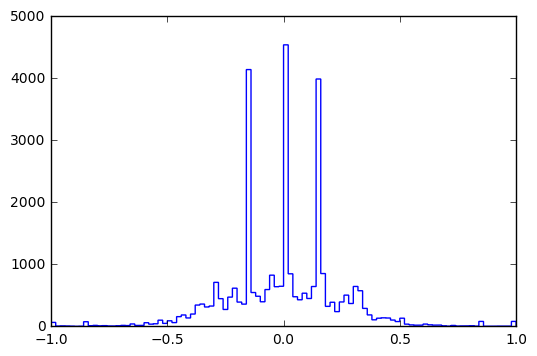

In [44]:
plt.hist(y_train,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

In [45]:
X_train, y_train = shuffle(X_train, y_train)

#### As you can see, most of our steering angles are around zero

## Preprocess

In [46]:
def preprocess_image(image):
    """
    Preprocess image, 
    input: image (original shape)
    output: image (shape is (220, 66, 3) )
    """    
    # crop shape
    image = image[image.shape[0] * 0.34:image.shape[0] * 0.875,:,:]
    # resize to (66, 220)
    img = cv2.resize(image, (220, 66), interpolation=cv2.INTER_AREA)
    return img


In [47]:
def preprocess_image_valid_from_path(image_path, steering_angle):
    img = mpimg.imread(image_path)
    img = preprocess_image(img)
    return img, steering_angle

In [48]:
def preprocess_image_from_path(image_path, steering_angle):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = preprocess_image(img)
    return img, steering_angle

## Generator

Here I created two generators, one for training data and one for validation data. In the training generator we create batches of 32 for each training sample. Therefore if I have `samples_per_epoch = 10` that means for each of those samples I yield 32 images from the training generator. I did this because it allows me to have control over what the batches turn out to be. In this case [ADD HERE]```add here I will add a probability function to pass a certain image path to the processor```

In [49]:

def generate_training_data(X_train, y_train, batch_size):
    """
    We create a loop through out data and 
    send out an individual row in the dataframe to preprocess_image_from_path, 
    which is then sent to preprocess_image
    inputs: 
    X_train: numpy array of X_training data (image paths),
    y_train: numpy array of measurements (steering angles)
    batch_size: batch sizes, size to make each batch
    returns a yield (image_batch, label_batch)
    """
    image_batch = np.zeros((batch_size * 2, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size * 2))
    while True:
        for i in range(batch_size):
            
            idx = np.random.randint(len(X_train))
            x, y = preprocess_image_from_path(X_train[idx], y_train[idx])
            
             # flip an image and return it
            x2 = np.fliplr(x)
            y2 = -1 * y
            
            image_batch[i] = x
            label_batch[i] = y
            
            image_batch[i+1] = x2
            image_batch[i+1] = y2
        yield image_batch, label_batch

In [50]:
def generate_validation_data(X_valid, y_valid):
    while True:
        for idx in range(len(X_valid)):
            img, angle = preprocess_image_valid_from_path(X_valid[idx], y_valid[idx])
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle

## Network

#### I chose to use Nvidia's network architecture. Input (220 x 66 sized image) output (1 steering angle)

I chose to use the Nvidia model architecture which can be found [here add link]
I used ELu's because they push mean unit activation functions closer to zero [https://arxiv.org/pdf/1511.07289v1.pdf]

In [51]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = (66, 220, 3)))
    # cropping 70 off top 25 off bottom
    # model.add(Cropping2D(cropping=((70,25), (0, 0)))) Probably going to do cropping in my process

    # subsample is strides
    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model


Using TensorFlow backend.


In [52]:
val_size = len(X_valid)
valid_generator = generate_validation_data(X_valid, y_valid)

In [53]:
model = nvidia_model()
for i in range(3):
    train_generator = generate_training_data(X_train, y_train, 128)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = len(X_train), # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weightsA6.h5')
    model.save('modelA6.h5')

Epoch 1/6


/home/jj/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


32512/32553 [============================>.] - ETA: 0s - loss: 0.0282

/home/jj/anaconda2/envs/python3/lib/python3.5/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


32768/32553 [==============================] - 49s - loss: 0.0282 - val_loss: 0.0507
Epoch 2/6
32768/32553 [==============================] - 47s - loss: 0.0253 - val_loss: 0.0479
Epoch 3/6
32768/32553 [==============================] - 46s - loss: 0.0240 - val_loss: 0.0483
Epoch 4/6
32768/32553 [==============================] - 48s - loss: 0.0229 - val_loss: 0.0472
Epoch 5/6
32768/32553 [==============================] - 48s - loss: 0.0240 - val_loss: 0.0459
Epoch 6/6
32768/32553 [==============================] - 45s - loss: 0.0238 - val_loss: 0.0459
Epoch 1/6
32768/32553 [==============================] - 38s - loss: 0.0234 - val_loss: 0.0463
Epoch 2/6
32768/32553 [==============================] - 35s - loss: 0.0229 - val_loss: 0.0470
Epoch 3/6
32768/32553 [==============================] - 36s - loss: 0.0227 - val_loss: 0.0458
Epoch 4/6
32768/32553 [==============================] - 38s - loss: 0.0226 - val_loss: 0.0460
Epoch 5/6
32768/32553 [==============================] - 33s

## Visualizing Loss

dict_keys(['val_loss', 'loss'])


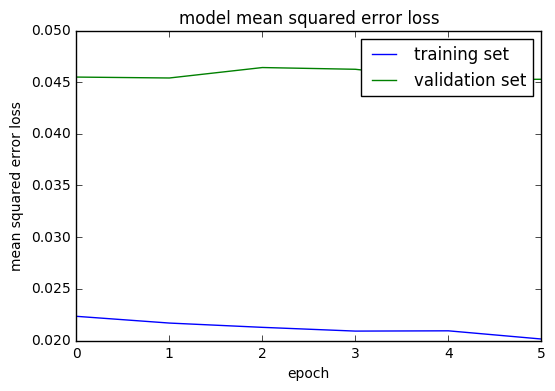

In [54]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()